# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import  multivariate_normal
from sklearn.mixture import GaussianMixture
from sklearn.datasets import make_blobs


# Dataset creation

<Axes: xlabel='x coord', ylabel='y coord'>

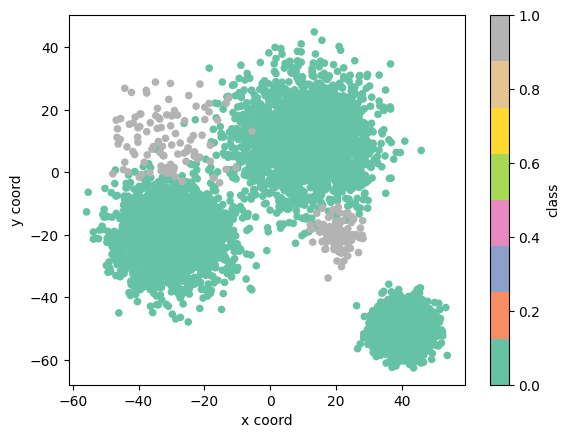

In [2]:
maj_centers = [[10,10],[-30,-20],[40,-50]]
min_centers = [[-30,10],[20,-20]]
maj_cov = [[[100,0],[0,100]],[[64,0],[0,64]],[[16,0],[0,16]]]
min_cov = [[[100,0],[0,100]],[[16,0],[0,16]]]
maj_std = [10, 8, 4]
min_std = [10, 4]

maj_samples = 7500
min_samples = 200

X, y = make_blobs(n_samples=maj_samples, centers= maj_centers, cluster_std=maj_std)

A, b = make_blobs(n_samples=min_samples, centers= min_centers, cluster_std=min_std)


blobs = pd.DataFrame()
blobs['x coord'] = X[:,0]
blobs['y coord'] = X[:,1]
blobs['class'] = 0
blobs1 = pd.DataFrame()
blobs1['x coord'] = A[:,0]
blobs1['y coord'] = A[:,1]
blobs1['class'] = 1
blobs = pd.concat([blobs, blobs1], axis=0)
blobs = blobs.reset_index(drop=True)
blobs.plot.scatter(x='x coord', y='y coord', c='class', cmap='Set2')


In [3]:
blobs.head()

,x coord,y coord,class
0,31.954995,-47.071363,0
1,-15.347235,-27.375415,0
2,37.474572,-49.611512,0
3,43.293651,-40.597578,0
4,7.033185,3.129979,0


In [4]:
def gaussian_pdf(x, mean, cov):
    return multivariate_normal(mean=mean, cov=cov).pdf(x)


def gmm_likelihood(X, weights, means, covs):
    """
    X: (N, 2) numpy array
    """
    prob = np.zeros(len(X))
    for w, m, c in zip(weights, means, covs):
        prob += w * np.array([gaussian_pdf(x, m, c) for x in X])
    return prob


In [5]:
# priors (true class proportions)
prior0 = maj_samples / (maj_samples + min_samples)
prior1 = min_samples / (maj_samples + min_samples)

X_all = blobs[['x coord', 'y coord']].values

# likelihoods
p_x_y0 = gmm_likelihood(
    X_all,
    weights=[1/3, 1/3, 1/3],
    means=maj_centers,
    covs=maj_cov
)

p_x_y1 = gmm_likelihood(
    X_all,
    weights=[1/2, 1/2],
    means=min_centers,
    covs=min_cov
)

# unnormalized posterior
post0 = p_x_y0 * prior0
post1 = p_x_y1 * prior1

# normalized minority posterior
p_minority = post1 / (post0 + post1)


In [6]:
tau = 0.3   # overlap threshold

blobs['cond'] = -1

# minority → D1 (cond = 2)
blobs.loc[blobs['class'] == 1, 'cond'] = 2

# overlap majority → D01 (cond = 1)
overlap_mask = (blobs['class'] == 0) & (p_minority > tau)
blobs.loc[overlap_mask, 'cond'] = 1

# clear majority → D00 (cond = 0)
clear_mask = (blobs['class'] == 0) & (p_minority <= tau)
blobs.loc[clear_mask, 'cond'] = 0

blobs['cond'].value_counts()


,count
cond,
0,7462
2,200
1,38


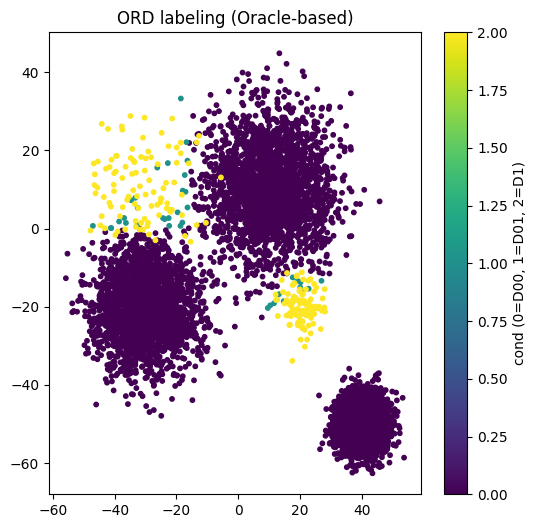

In [7]:
plt.figure(figsize=(6,6))
plt.scatter(
    blobs['x coord'],
    blobs['y coord'],
    c=blobs['cond'],
    cmap='viridis',
    s=10
)
plt.colorbar(label='cond (0=D00, 1=D01, 2=D1)')
plt.title('ORD labeling (Oracle-based)')
plt.show()


## **ORD-training**

In [8]:
# no-ORD training data
X_no_ord = blobs[['x coord', 'y coord']].values
y_no_ord = blobs['class'].values

print(X_no_ord.shape, y_no_ord.shape)


(7700, 2) (7700,)


In [9]:
# no-ORD training data
X_no_ord = blobs[['x coord', 'y coord']].values
y_no_ord = blobs['class'].values

print(X_no_ord.shape, y_no_ord.shape)


(7700, 2) (7700,)


In [10]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(blobs[['x coord', 'y coord']].values)

print(X_scaled.mean(axis=0), X_scaled.std(axis=0))


[ 4.61391387e-18 -9.59694085e-17] [1. 1.]


In [11]:
# no-ORD (scaled)
X_no_ord = X_scaled
y_no_ord = blobs['class'].values

# ORD (scaled)
X_ord = X_scaled
cond_ord = blobs['cond'].values.astype(int)


In [12]:
NUM_COND = 3        # D00, D01, D1
COND_EMB_DIM = 4


In [14]:
import torch
import torch.nn as nn
import math


In [15]:
class TimeEmbedding(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, t):
        half_dim = self.dim // 2
        emb = math.log(10000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=t.device) * -emb)
        emb = t[:, None] * emb[None, :]
        emb = torch.cat([torch.sin(emb), torch.cos(emb)], dim=1)
        return emb


In [16]:
class DiffusionModel(nn.Module):
    def __init__(self, x_dim=2, cond_dim=3, time_dim=16, cond_emb_dim=8, hidden_dim=128):
        super().__init__()

        self.time_emb = TimeEmbedding(time_dim)
        self.cond_emb = nn.Embedding(cond_dim, cond_emb_dim)

        input_dim = x_dim + time_dim + cond_emb_dim

        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, x_dim)
        )

    def forward(self, x, t, cond):
        """
        x: (B, 2)
        t: (B,)
        cond: (B,)
        """
        t_emb = self.time_emb(t)
        c_emb = self.cond_emb(cond)

        h = torch.cat([x, t_emb, c_emb], dim=1)
        return self.net(h)


In [17]:
import torch
import torch.nn.functional as F


In [20]:
T = 1000

beta_start = 1e-4
beta_end   = 0.02

betas = torch.linspace(beta_start, beta_end, T, device=device)
alphas = 1.0 - betas
alpha_bars = torch.cumprod(alphas, dim=0)



In [21]:
def q_sample(x0, t, noise):
    """
    x0: (B, 2)
    t: (B,)
    noise: (B, 2)
    """
    sqrt_alpha_bar = torch.sqrt(alpha_bars[t]).unsqueeze(1)
    sqrt_one_minus = torch.sqrt(1 - alpha_bars[t]).unsqueeze(1)
    return sqrt_alpha_bar * x0 + sqrt_one_minus * noise


In [22]:
X_tensor = torch.tensor(X_ord, dtype=torch.float32)
cond_tensor = torch.tensor(cond_ord, dtype=torch.long)


In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = DiffusionModel().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


In [24]:
EPOCHS = 50
BATCH_SIZE = 256

dataset = torch.utils.data.TensorDataset(X_tensor, cond_tensor)
loader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)


In [25]:
for epoch in range(EPOCHS):
    total_loss = 0.0

    for x0, cond in loader:
        x0 = x0.to(device)
        cond = cond.to(device)

        t = torch.randint(0, T, (x0.size(0),), device=device)
        noise = torch.randn_like(x0)

        xt = q_sample(x0, t, noise)
        noise_pred = model(xt, t, cond)

        loss = F.mse_loss(noise_pred, noise)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"[Epoch {epoch+1:03d}] Loss: {total_loss / len(loader):.6f}")


[Epoch 001] Loss: 0.558687
[Epoch 002] Loss: 0.318691
[Epoch 003] Loss: 0.285607
[Epoch 004] Loss: 0.277437
[Epoch 005] Loss: 0.264621
[Epoch 006] Loss: 0.259985
[Epoch 007] Loss: 0.261628
[Epoch 008] Loss: 0.257939
[Epoch 009] Loss: 0.241817
[Epoch 010] Loss: 0.243706
[Epoch 011] Loss: 0.230761
[Epoch 012] Loss: 0.249857
[Epoch 013] Loss: 0.235360
[Epoch 014] Loss: 0.231485
[Epoch 015] Loss: 0.226347
[Epoch 016] Loss: 0.211840
[Epoch 017] Loss: 0.219568
[Epoch 018] Loss: 0.231988
[Epoch 019] Loss: 0.230055
[Epoch 020] Loss: 0.219840
[Epoch 021] Loss: 0.221626
[Epoch 022] Loss: 0.222543
[Epoch 023] Loss: 0.213363
[Epoch 024] Loss: 0.213196
[Epoch 025] Loss: 0.214244
[Epoch 026] Loss: 0.212792
[Epoch 027] Loss: 0.214230
[Epoch 028] Loss: 0.208073
[Epoch 029] Loss: 0.207136
[Epoch 030] Loss: 0.202003
[Epoch 031] Loss: 0.208991
[Epoch 032] Loss: 0.206176
[Epoch 033] Loss: 0.215559
[Epoch 034] Loss: 0.209113
[Epoch 035] Loss: 0.206803
[Epoch 036] Loss: 0.198512
[Epoch 037] Loss: 0.214977
[

In [26]:
@torch.no_grad()
def p_sample(model, x, t, cond):
    """
    x: (B, 2)  current noisy sample x_t
    t: (B,)    timestep
    cond: (B,) condition
    """
    beta_t = betas[t].unsqueeze(1)
    alpha_t = alphas[t].unsqueeze(1)
    alpha_bar_t = alpha_bars[t].unsqueeze(1)

    eps_theta = model(x, t, cond)

    mean = (1 / torch.sqrt(alpha_t)) * (
        x - (beta_t / torch.sqrt(1 - alpha_bar_t)) * eps_theta
    )

    if t.min() == 0:
        return mean
    else:
        noise = torch.randn_like(x)
        return mean + torch.sqrt(beta_t) * noise


In [27]:
@torch.no_grad()
def sample_diffusion(model, n_samples, cond_value):
    model.eval()

    x = torch.randn(n_samples, 2, device=device)

    cond = torch.full((n_samples,), cond_value, device=device, dtype=torch.long)

    for t in reversed(range(T)):
        t_batch = torch.full((n_samples,), t, device=device, dtype=torch.long)
        x = p_sample(model, x, t_batch, cond)

    return x.cpu().numpy()


## **no-ord**

In [28]:
# minority only for no-ORD training
X_no_ord = blobs[blobs["class"] == 1][["x coord", "y coord"]].values
X_no_ord = scaler.transform(X_no_ord)


In [29]:
# Tensor
X_no_ord_tensor = torch.tensor(X_no_ord, dtype=torch.float32)

# Dataset, Loader
dataset_no_ord = torch.utils.data.TensorDataset(X_no_ord_tensor)
loader_no_ord = torch.utils.data.DataLoader(dataset_no_ord, batch_size=256, shuffle=True)


In [30]:
class DiffusionModelNoORD(nn.Module):
    def __init__(self, x_dim=2, time_dim=16, hidden_dim=128):
        super().__init__()
        self.time_emb = TimeEmbedding(time_dim)
        input_dim = x_dim + time_dim

        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, x_dim),
        )

    def forward(self, x, t):
        t_emb = self.time_emb(t)
        h = torch.cat([x, t_emb], dim=1)
        return self.net(h)


In [31]:
model_no_ord = DiffusionModelNoORD().to(device)
optimizer_no_ord = torch.optim.Adam(model_no_ord.parameters(), lr=1e-3)

EPOCHS = 50

for epoch in range(EPOCHS):
    total_loss = 0.0

    for (x0,) in loader_no_ord:
        x0 = x0.to(device)

        t = torch.randint(0, T, (x0.size(0),), device=device)
        noise = torch.randn_like(x0)

        xt = q_sample(x0, t, noise)
        noise_pred = model_no_ord(xt, t)

        loss = F.mse_loss(noise_pred, noise)

        optimizer_no_ord.zero_grad()
        loss.backward()
        optimizer_no_ord.step()

        total_loss += loss.item()

    print(f"[No-ORD Epoch {epoch+1:03d}] Loss: {total_loss / len(loader_no_ord):.6f}")


[No-ORD Epoch 001] Loss: 1.209934
[No-ORD Epoch 002] Loss: 0.907693
[No-ORD Epoch 003] Loss: 1.134713
[No-ORD Epoch 004] Loss: 0.942996
[No-ORD Epoch 005] Loss: 0.906572
[No-ORD Epoch 006] Loss: 0.804229
[No-ORD Epoch 007] Loss: 0.827831
[No-ORD Epoch 008] Loss: 0.747312
[No-ORD Epoch 009] Loss: 0.788526
[No-ORD Epoch 010] Loss: 0.758634
[No-ORD Epoch 011] Loss: 0.662183
[No-ORD Epoch 012] Loss: 0.805727
[No-ORD Epoch 013] Loss: 0.688231
[No-ORD Epoch 014] Loss: 0.668995
[No-ORD Epoch 015] Loss: 0.605370
[No-ORD Epoch 016] Loss: 0.702445
[No-ORD Epoch 017] Loss: 0.555120
[No-ORD Epoch 018] Loss: 0.528763
[No-ORD Epoch 019] Loss: 0.541941
[No-ORD Epoch 020] Loss: 0.415255
[No-ORD Epoch 021] Loss: 0.401969
[No-ORD Epoch 022] Loss: 0.416266
[No-ORD Epoch 023] Loss: 0.400270
[No-ORD Epoch 024] Loss: 0.293993
[No-ORD Epoch 025] Loss: 0.304135
[No-ORD Epoch 026] Loss: 0.377716
[No-ORD Epoch 027] Loss: 0.327282
[No-ORD Epoch 028] Loss: 0.299965
[No-ORD Epoch 029] Loss: 0.266272
[No-ORD Epoch 

In [32]:
@torch.no_grad()
def p_sample_no_ord(model, x, t):
    beta_t = betas[t].unsqueeze(1)
    alpha_t = alphas[t].unsqueeze(1)
    alpha_bar_t = alpha_bars[t].unsqueeze(1)

    eps_theta = model(x, t)

    mean = (1 / torch.sqrt(alpha_t)) * (
        x - (beta_t / torch.sqrt(1 - alpha_bar_t)) * eps_theta
    )

    if t.min() == 0:
        return mean
    else:
        return mean + torch.sqrt(beta_t) * torch.randn_like(x)


@torch.no_grad()
def sample_diffusion_no_ord(model, n_samples):
    model.eval()
    x = torch.randn(n_samples, 2, device=device)

    for t in reversed(range(T)):
        t_batch = torch.full((n_samples,), t, device=device, dtype=torch.long)
        x = p_sample_no_ord(model, x, t_batch)

    return x.cpu().numpy()


In [33]:
N_SYN = 1500

# -------------------------------
# 1) No-ORD: minority-only diffusion baseline
# -------------------------------
syn_no_ord_scaled = sample_diffusion_no_ord(
    model_no_ord,
    n_samples=N_SYN
)

# -------------------------------
# 2) ORD: conditional diffusion (cond = 2 → D1 minority area)
# -------------------------------
syn_ord_scaled = sample_diffusion(
    model,
    n_samples=N_SYN,
    cond_value=2     # minority region
)

# -------------------------------
# 3) Inverse transform to original coordinate scale
# -------------------------------
syn_no_ord_orig = scaler.inverse_transform(syn_no_ord_scaled)
syn_ord_orig = scaler.inverse_transform(syn_ord_scaled)


In [34]:
from scipy.stats import multivariate_normal
import numpy as np


In [35]:
def compute_gmm_probability(points, weights, means, covariances):
    prob = np.zeros(points.shape[0])
    for w, m, c in zip(weights, means, covariances):
        prob += w * multivariate_normal(mean=m, cov=c).pdf(points)
    return prob


In [36]:
def oracle_predict(points):
    """
    points: (N, 2) numpy (original scale!)
    return: 0=majority, 1=minority
    """
    prior0 = maj_samples / (maj_samples + min_samples)
    prior1 = min_samples / (maj_samples + min_samples)

    p0 = compute_gmm_probability(
        points, gmm0.weights_, gmm0.means_, gmm0.covariances_
    ) * prior0

    p1 = compute_gmm_probability(
        points, gmm1.weights_, gmm1.means_, gmm1.covariances_
    ) * prior1

    return (p1 > p0).astype(int)


In [37]:
from sklearn.mixture import GaussianMixture

# Majority oracle GMM
gmm0 = GaussianMixture(n_components=3, random_state=42)
gmm0.weights_ = np.array([1/3, 1/3, 1/3])
gmm0.means_ = np.array(maj_centers)
gmm0.covariances_ = np.array(maj_cov)
gmm0.precisions_cholesky_ = np.linalg.cholesky(
    np.linalg.inv(gmm0.covariances_)
)

# Minority oracle GMM
gmm1 = GaussianMixture(n_components=2, random_state=42)
gmm1.weights_ = np.array([1/2, 1/2])
gmm1.means_ = np.array(min_centers)
gmm1.covariances_ = np.array(min_cov)
gmm1.precisions_cholesky_ = np.linalg.cholesky(
    np.linalg.inv(gmm1.covariances_)
)


In [38]:
pred_no_ord = oracle_predict(syn_no_ord_orig)
pred_ord = oracle_predict(syn_ord_orig)

wrong_no_ord = (pred_no_ord == 0).mean()
wrong_ord = (pred_ord == 0).mean()

print(f"Wrong generation (no-ORD): {wrong_no_ord:.4f}")
print(f"Wrong generation (ORD):    {wrong_ord:.4f}")


Wrong generation (no-ORD): 0.6533
Wrong generation (ORD):    0.2940


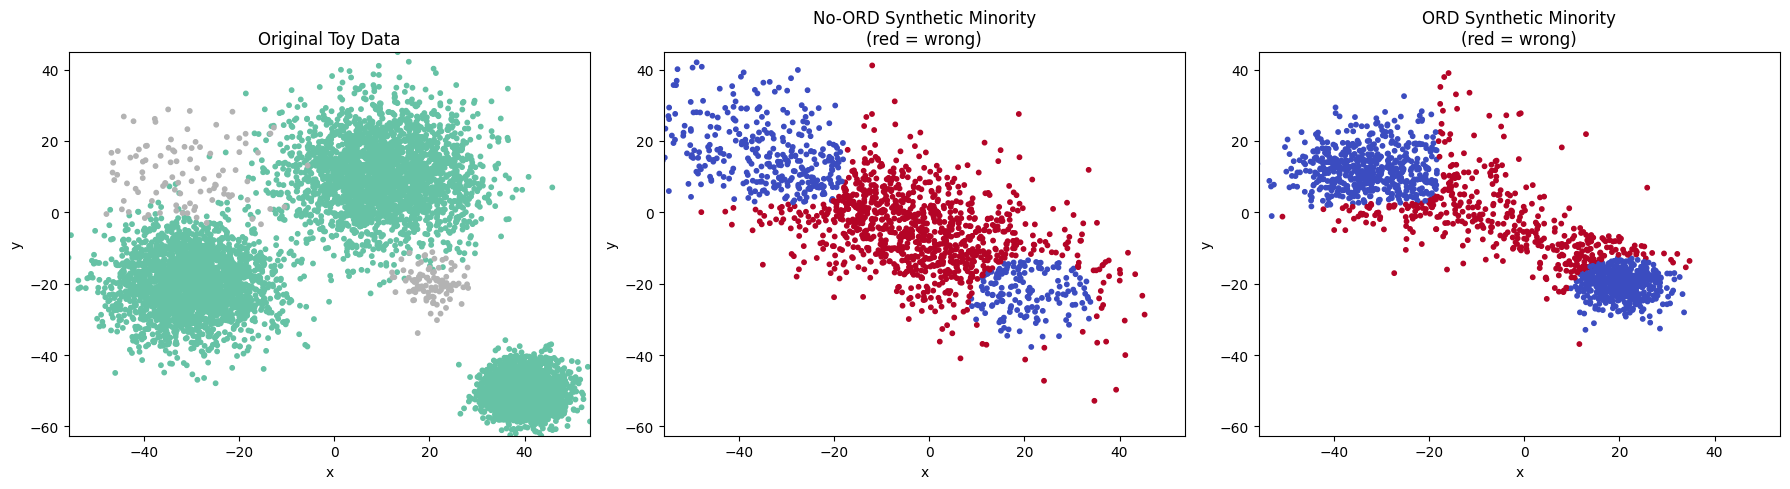

In [39]:
# ----------------------------------
# axis range based on original blobs
# ----------------------------------
x_min, x_max = blobs['x coord'].min(), blobs['x coord'].max()
y_min, y_max = blobs['y coord'].min(), blobs['y coord'].max()

plt.figure(figsize=(18,5))

# -----------------------------
# (1) Original blob data
# -----------------------------
plt.subplot(1,3,1)
plt.scatter(
    blobs['x coord'],
    blobs['y coord'],
    c=blobs['class'],
    cmap='Set2',
    s=10
)
plt.title('Original Toy Data')
plt.xlabel('x')
plt.ylabel('y')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)

# -----------------------------
# (2) no-ORD synthetic minority
# -----------------------------
plt.subplot(1,3,2)
plt.scatter(
    syn_no_ord_orig[:,0],
    syn_no_ord_orig[:,1],
    c=(pred_no_ord == 0),   # True = wrong (majority)
    cmap='coolwarm',
    s=10
)
plt.title('No-ORD Synthetic Minority\n(red = wrong)')
plt.xlabel('x')
plt.ylabel('y')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)

# -----------------------------
# (3) ORD synthetic minority
# -----------------------------
plt.subplot(1,3,3)
plt.scatter(
    syn_ord_orig[:,0],
    syn_ord_orig[:,1],
    c=(pred_ord == 0),      # True = wrong (majority)
    cmap='coolwarm',
    s=10
)
plt.title('ORD Synthetic Minority\n(red = wrong)')
plt.xlabel('x')
plt.ylabel('y')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)

plt.tight_layout()
plt.show()


## **HP tuning**

In [45]:
import pandas as pd
import torch
import torch.nn.functional as F
import numpy as np
import random

RESULTS = []

COND_EMB_LIST = [4, 6, 8, 10, 12]
SEEDS = [0, 1, 2, 3, 4]

N_SYN = 1500
EPOCHS = 40
BATCH_SIZE = 256
LR = 1e-3


# ----------------------------------
# Seed fixing 함수
# ----------------------------------
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)


# ----------------------------------
# minority-only dataset for No-ORD
# ----------------------------------
X_minority = X_ord[cond_ord == 2]   # cond=2 = minority
X_minority_tensor = torch.tensor(X_minority, dtype=torch.float32)


# ================================================================
#                   Hyperparameter Sweep Loop
# ================================================================
for COND_EMB_DIM in COND_EMB_LIST:
    print(f"\n===== COND_EMB_DIM = {COND_EMB_DIM} =====")

    no_ord_list = []
    ord_list = []

    # =========================
    # 5 seeds 반복
    # =========================
    for seed in SEEDS:
        print(f"  Seed {seed}")
        set_seed(seed)

        # ----------------------------------------------------------
        # 1) ORD 모델 생성 및 학습 (Conditional Diffusion Model)
        # ----------------------------------------------------------
        model_ord = DiffusionModel(
            x_dim=2,
            cond_dim=3,
            time_dim=16,
            cond_emb_dim=COND_EMB_DIM,
            hidden_dim=128
        ).to(device)

        optimizer_ord = torch.optim.Adam(model_ord.parameters(), lr=LR)

        dataset_ord = torch.utils.data.TensorDataset(
            torch.tensor(X_ord, dtype=torch.float32),
            torch.tensor(cond_ord, dtype=torch.long)
        )
        loader_ord = torch.utils.data.DataLoader(
            dataset_ord, batch_size=BATCH_SIZE, shuffle=True
        )

        # ----- Train ORD -----
        for epoch in range(EPOCHS):
            for x0, cond in loader_ord:
                x0 = x0.to(device)
                cond = cond.to(device)

                t = torch.randint(0, T, (x0.size(0),), device=device)
                noise = torch.randn_like(x0)

                xt = q_sample(x0, t, noise)
                noise_pred = model_ord(xt, t, cond)

                loss = F.mse_loss(noise_pred, noise)
                optimizer_ord.zero_grad()
                loss.backward()
                optimizer_ord.step()


        # ----------------------------------------------------------
        # 2) No-ORD 모델 생성 및 학습 (Unconditional Minor Model)
        # ----------------------------------------------------------
        model_no_ord = DiffusionModelNoORD(
            x_dim=2,
            time_dim=16,
            hidden_dim=128
        ).to(device)

        optimizer_no_ord = torch.optim.Adam(model_no_ord.parameters(), lr=LR)

        dataset_no_ord = torch.utils.data.TensorDataset(X_minority_tensor)
        loader_no_ord = torch.utils.data.DataLoader(
            dataset_no_ord, batch_size=BATCH_SIZE, shuffle=True
        )

        # ----- Train No-ORD -----
        for epoch in range(EPOCHS):
            for (x0,) in loader_no_ord:
                x0 = x0.to(device)

                t = torch.randint(0, T, (x0.size(0),), device=device)
                noise = torch.randn_like(x0)

                xt = q_sample(x0, t, noise)
                noise_pred = model_no_ord(xt, t)

                loss = F.mse_loss(noise_pred, noise)
                optimizer_no_ord.zero_grad()
                loss.backward()
                optimizer_no_ord.step()


        # ----------------------------------------------------------
        # 3) Sampling (두 모델 동시 생성)
        # ----------------------------------------------------------
        syn_no_ord = sample_diffusion_no_ord(model_no_ord, n_samples=N_SYN)
        syn_ord = sample_diffusion(model_ord, n_samples=N_SYN, cond_value=2)

        syn_no_ord_orig = scaler.inverse_transform(syn_no_ord)
        syn_ord_orig = scaler.inverse_transform(syn_ord)


        # ----------------------------------------------------------
        # 4) Oracle 평가
        # ----------------------------------------------------------
        pred_no_ord = oracle_predict(syn_no_ord_orig)
        pred_ord = oracle_predict(syn_ord_orig)

        no_ord_list.append((pred_no_ord == 0).mean())
        ord_list.append((pred_ord == 0).mean())


    # ================================================================
    #             5 seeds 평균/표준편차 결과 기록
    # ================================================================
    RESULTS.append({
        "COND_EMB_DIM": COND_EMB_DIM,
        "Wrong_noORD_mean": np.mean(no_ord_list),
        "Wrong_noORD_std":  np.std(no_ord_list),
        "Wrong_ORD_mean":   np.mean(ord_list),
        "Wrong_ORD_std":    np.std(ord_list),
    })


# ================================================================
#                     Final Result DataFrame
# ================================================================
df_results = pd.DataFrame(RESULTS)
df_results



===== COND_EMB_DIM = 4 =====
  Seed 0
  Seed 1
  Seed 2
  Seed 3
  Seed 4

===== COND_EMB_DIM = 6 =====
  Seed 0
  Seed 1
  Seed 2
  Seed 3
  Seed 4

===== COND_EMB_DIM = 8 =====
  Seed 0
  Seed 1
  Seed 2
  Seed 3
  Seed 4

===== COND_EMB_DIM = 10 =====
  Seed 0
  Seed 1
  Seed 2
  Seed 3
  Seed 4

===== COND_EMB_DIM = 12 =====
  Seed 0
  Seed 1
  Seed 2
  Seed 3
  Seed 4


,COND_EMB_DIM,Wrong_noORD_mean,Wrong_noORD_std,Wrong_ORD_mean,Wrong_ORD_std
0,4,0.776800,0.031342,0.361067,0.021556
1,6,0.802667,0.027390,0.358800,0.060101
2,8,0.768267,0.029287,0.349200,0.033515
3,10,0.767067,0.003058,0.353467,0.027676
4,12,0.773467,0.035012,0.311200,0.026920


## **ablation study**

In [58]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs

# -----------------------------
# 설정
# -----------------------------
maj_centers = [[0, 0], [0, 40], [40, 0]]
min_centers = [[80, 120]]
maj_std = [6, 6, 6]
min_std = [5]

maj_samples = 7500
min_samples = 200


X_maj, _ = make_blobs(
    n_samples=maj_samples,
    centers=maj_centers,
    cluster_std=maj_std,
    random_state=42
)

X_min, _ = make_blobs(
    n_samples=min_samples,
    centers=min_centers,
    cluster_std=min_std,
    random_state=42
)

blobs_maj = pd.DataFrame(X_maj, columns=["x coord", "y coord"])
blobs_maj["class"] = 0   # majority

blobs_min = pd.DataFrame(X_min, columns=["x coord", "y coord"])
blobs_min["class"] = 1   # minority

blobs = pd.concat([blobs_maj, blobs_min], axis=0).reset_index(drop=True)



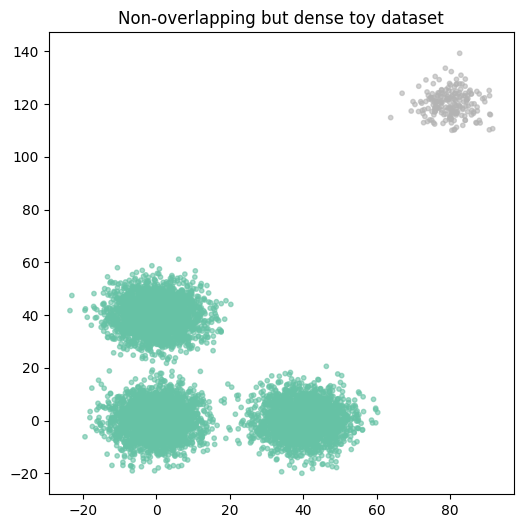

In [59]:
plt.figure(figsize=(6,6))
plt.scatter(
    blobs["x coord"],
    blobs["y coord"],
    c=blobs["class"],
    cmap="Set2",
    s=10,
    alpha=0.6
)
plt.title("Non-overlapping but dense toy dataset")
plt.show()


In [60]:
from sklearn.preprocessing import StandardScaler
import torch

# feature / label
X = blobs[["x coord", "y coord"]].values
y = blobs["class"].values   # 0=majority, 1=minority

# scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


cond = y.astype(int)

# torch tensor
X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
cond_tensor = torch.tensor(cond, dtype=torch.long)

print(X_tensor.shape, cond_tensor.shape)


torch.Size([7700, 2]) torch.Size([7700])


In [61]:
model_no_ord = DiffusionModel(
    x_dim=2,
    cond_dim=2,
    time_dim=16,
    cond_emb_dim=8,
    hidden_dim=128
).to(device)

optimizer = torch.optim.Adam(model_no_ord.parameters(), lr=1e-3)

dataset = torch.utils.data.TensorDataset(X_tensor, cond_tensor)
loader = torch.utils.data.DataLoader(dataset, batch_size=256, shuffle=True)

EPOCHS = 40

for epoch in range(EPOCHS):
    for x0, c in loader:
        x0 = x0.to(device)
        c = c.to(device)

        t = torch.randint(0, T, (x0.size(0),), device=device)
        noise = torch.randn_like(x0)

        xt = q_sample(x0, t, noise)
        noise_pred = model_no_ord(xt, t, c)

        loss = torch.nn.functional.mse_loss(noise_pred, noise)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if epoch % 10 == 0:
        print(f"[no-ORD] epoch {epoch}, loss {loss.item():.4f}")


[no-ORD] epoch 0, loss 0.1779
[no-ORD] epoch 10, loss 0.2283
[no-ORD] epoch 20, loss 0.2250
[no-ORD] epoch 30, loss 0.2376


In [62]:
model_ord = DiffusionModel(
    x_dim=2,
    cond_dim=2,
    time_dim=16,
    cond_emb_dim=8,
    hidden_dim=128
).to(device)

optimizer = torch.optim.Adam(model_ord.parameters(), lr=1e-3)


mask_min = cond_tensor == 1

dataset_ord = torch.utils.data.TensorDataset(
    X_tensor[mask_min],
    cond_tensor[mask_min]
)

loader_ord = torch.utils.data.DataLoader(
    dataset_ord, batch_size=128, shuffle=True
)

for epoch in range(EPOCHS):
    for x0, c in loader_ord:
        x0 = x0.to(device)
        c = c.to(device)

        t = torch.randint(0, T, (x0.size(0),), device=device)
        noise = torch.randn_like(x0)

        xt = q_sample(x0, t, noise)
        noise_pred = model_ord(xt, t, c)

        loss = torch.nn.functional.mse_loss(noise_pred, noise)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if epoch % 10 == 0:
        print(f"[ORD] epoch {epoch}, loss {loss.item():.4f}")


[ORD] epoch 0, loss 0.8470
[ORD] epoch 10, loss 0.4754
[ORD] epoch 20, loss 0.2312
[ORD] epoch 30, loss 0.1876


In [63]:
N_SYN = 1000


syn_no_ord = sample_diffusion(
    model_no_ord,
    n_samples=N_SYN,
    cond_value=1
)

syn_ord = sample_diffusion(
    model_ord,
    n_samples=N_SYN,
    cond_value=1
)

# inverse scaling
syn_no_ord_orig = scaler.inverse_transform(syn_no_ord)
syn_ord_orig = scaler.inverse_transform(syn_ord)


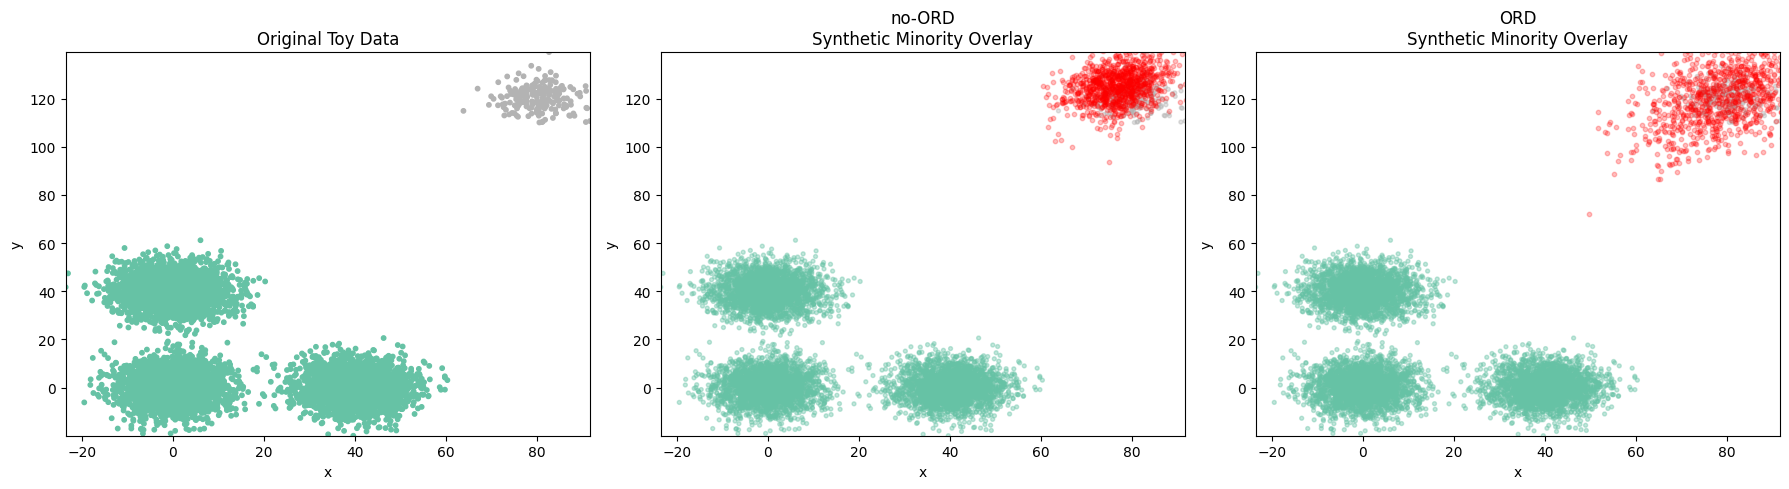

In [65]:
import matplotlib.pyplot as plt
import numpy as np

# -----------------------------
# axis range (original scale)
# -----------------------------
x_min, x_max = blobs["x coord"].min(), blobs["x coord"].max()
y_min, y_max = blobs["y coord"].min(), blobs["y coord"].max()

plt.figure(figsize=(18,5))

# =============================
# (1) Original toy data
# =============================
plt.subplot(1,3,1)
plt.scatter(
    blobs["x coord"],
    blobs["y coord"],
    c=blobs["class"],
    cmap="Set2",
    s=10
)
plt.title("Original Toy Data")
plt.xlabel("x")
plt.ylabel("y")
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)

# =============================
# (2) no-ORD (overlay)
# =============================
plt.subplot(1,3,2)

# original data (background)
plt.scatter(
    blobs["x coord"],
    blobs["y coord"],
    c=blobs["class"],
    cmap="Set2",
    s=8,
    alpha=0.4
)

# synthetic minority (overlay)
plt.scatter(
    syn_no_ord_orig[:,0],
    syn_no_ord_orig[:,1],
    color="red",
    alpha=0.25,
    s=10
)

plt.title("no-ORD\nSynthetic Minority Overlay")
plt.xlabel("x")
plt.ylabel("y")
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)

# =============================
# (3) ORD (overlay)
# =============================
plt.subplot(1,3,3)

# original data (background)
plt.scatter(
    blobs["x coord"],
    blobs["y coord"],
    c=blobs["class"],
    cmap="Set2",
    s=8,
    alpha=0.4
)

# synthetic minority (overlay)
plt.scatter(
    syn_ord_orig[:,0],
    syn_ord_orig[:,1],
    color="red",
    alpha=0.25,
    s=10
)

plt.title("ORD\nSynthetic Minority Overlay")
plt.xlabel("x")
plt.ylabel("y")
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)

plt.tight_layout()
plt.show()
